# <center>Catch Me If You Can ("Alice")</center>

## Introduction

Here we try to identify a user on the Internet tracking his/her sequence of attended Web pages.  
The algorithm to be built will take a webpage session (a sequence of webpages attended consequently by the same person)  
and predict whether it belongs to Alice or somebody else.

The data comes from Blaise Pascal University proxy servers.  
Paper "A Tool for Classification of Sequential Data" by Giacomo Kahn, Yannick Loiseau and Olivier Raynaud.

### **Plan:**
* New features creation
* Data analysis and visualization
* Comparative analysis of different models

### **Link to kaggle competition:**
* [Catch Me If You Can ("Alice")](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#WARNING! Working with local data please find them in <dataset/ML_Weekly/5/dataset.zip>

# Read the training and test data sets
train_df = pd.read_csv('./data/train_sessions.csv',
                       index_col='session_id',parse_dates=['time1'])
test_df = pd.read_csv('./data/test_sessions.csv',
                      index_col='session_id',parse_dates=['time1'])

print(f"train_df shape: {train_df.shape}, test_df shape: {test_df.shape}")

times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

train_df shape: (253561, 21), test_df shape: (82797, 20)


In [ ]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

**User sessions** are chosen in the way they are not longer than half an hour or/and contain more than ten websites.  
I.e. a session is considered as ended either if a user has visited ten websites or if a session has lasted over thirty minutes.

In [ ]:
full_df.head(5)

site1               time1  site2               time2  site3  \
session_id                                                                
21669          56 2013-01-12 08:05:57     55 2013-01-12 08:05:57      0   
54843          56 2013-01-12 08:37:23     55 2013-01-12 08:37:23     56   
77292         946 2013-01-12 08:50:13    946 2013-01-12 08:50:14    951   
114021        945 2013-01-12 08:50:17    948 2013-01-12 08:50:17    949   
146670        947 2013-01-12 08:50:20    950 2013-01-12 08:50:20    948   

                         time3  site4               time4  site5  \
session_id                                                         
21669                      NaT      0                 NaT      0   
54843      2013-01-12 09:07:07     55 2013-01-12 09:07:09      0   
77292      2013-01-12 08:50:15    946 2013-01-12 08:50:15    946   
114021     2013-01-12 08:50:18    948 2013-01-12 08:50:18    945   
146670     2013-01-12 08:50:20    947 2013-01-12 08:50:21    950   

                         time5  site6               time6  site7  \
session_id                                                         
21669                      NaT      0                 NaT      0   
54843                      NaT      0                 NaT      0   
77292      2013-01-12 08:50:16    945 2013-01-12 08:50:16    948   
114021     2013-01-12 08:50:18    946 2013-01-12 08:50:18    947   
146670     2013-01-12 08:50:21    952 2013-01-12 08:50:21    946   

                         time7  site8               time8  site9  \
session_id                                                         
21669                      NaT      0                 NaT      0   
54843                      NaT      0                 NaT      0   
77292      2013-01-12 08:50:16    784 2013-01-12 08:50:16    949   
114021     2013-01-12 08:50:19    945 2013-01-12 08:50:19    946   
146670     2013-01-12 08:50:21    951 2013-01-12 08:50:22    946   

                         time9  site10              time10  
session_id                                                  
21669                      NaT       0                 NaT  
54843                      NaT       0                 NaT  
77292      2013-01-12 08:50:17     946 2013-01-12 08:50:17  
114021     2013-01-12 08:50:19     946 2013-01-12 08:50:20  
146670     2013-01-12 08:50:22     947 2013-01-12 08:50:22

In [ ]:
full_sites = full_df[sites] #only sites
full_sites.head(3)

site1  site2  site3  site4  site5  site6  site7  site8  site9  \
session_id                                                                  
21669          56     55      0      0      0      0      0      0      0   
54843          56     55     56     55      0      0      0      0      0   
77292         946    946    951    946    946    945    948    784    949   

            site10  
session_id          
21669            0  
54843            0  
77292          946

## **Bag of words**  
A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:  
* A vocabulary of known words.
* A measure of the presence of known words.

## **Bag of words with CountVectorizer() example:**
>```vectorizer = CountVectorizer()
corpus = [
  'site_1 site_2 site_3',
  'site_2 site_3',
  'site_1 site_2 site_1',
  'site_4'
]
X = vectorizer.fit_transform(corpus)
```
 
>result:

>| | site_1 | site_2 | site_3 | site_4
 :---: | :---: | :---: | :---: | :---:
session_1 | 1 | 1 | 1 | 0
session_2 | 0 | 1 | 1 | 0
session_3 | 2 | 1 | 0 | 0
session_4 | 0 | 0 | 0 | 1

In [ ]:
# Fit CountVectorizer and trasfrom data with it.
full_sites = full_sites.astype('str')
lst = full_sites[sites].as_matrix().tolist()
flat_list = [' '.join(sublist) for sublist in lst]
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
sites_matrix = cv.fit_transform(flat_list)

# Splitting back into training and test samples
train_sites_matrix = sites_matrix[:idx_split]
test_sites_matrix  = sites_matrix[idx_split:]

print(f"train_sites_matrix shape: {train_sites_matrix.shape}, test_sites_matrix shape: {test_sites_matrix.shape}")

cv.get_feature_names()[:10]

train_sites_matrix shape: (253561, 50000), test_sites_matrix shape: (82797, 50000)


['10',
 '10 1086',
 '10 11',
 '10 11 12',
 '10 11 14',
 '10 11 15',
 '10 11241',
 '10 1199',
 '10 12',
 '10 1200']

In [ ]:
full_time = full_df[times] 
full_time.head(3)

time1               time2               time3  \
session_id                                                               
21669      2013-01-12 08:05:57 2013-01-12 08:05:57                 NaT   
54843      2013-01-12 08:37:23 2013-01-12 08:37:23 2013-01-12 09:07:07   
77292      2013-01-12 08:50:13 2013-01-12 08:50:14 2013-01-12 08:50:15   

                         time4               time5               time6  \
session_id                                                               
21669                      NaT                 NaT                 NaT   
54843      2013-01-12 09:07:09                 NaT                 NaT   
77292      2013-01-12 08:50:15 2013-01-12 08:50:16 2013-01-12 08:50:16   

                         time7               time8               time9  \
session_id                                                               
21669                      NaT                 NaT                 NaT   
54843                      NaT                 NaT                 NaT   
77292      2013-01-12 08:50:16 2013-01-12 08:50:16 2013-01-12 08:50:17   

                        time10  
session_id                      
21669                      NaT  
54843                      NaT  
77292      2013-01-12 08:50:17

In [ ]:
def add_features(time_df):
    start_hour = time_df['time1'].apply(lambda ts: ts.hour)
    additional_data_df = pd.DataFrame(data=start_hour.values, columns=['start_hour'], index=start_hour.index)
    additional_data_df['morning'] = ((start_hour >= 7) & (start_hour <= 11)).astype('int').values.reshape(-1, 1)
    additional_data_df['midday'] = ((start_hour >= 12) & (start_hour <= 18)).astype('int').values.reshape(-1, 1)
    additional_data_df['evening'] = ((start_hour >= 19) & (start_hour <= 23)).astype('int').values.reshape(-1, 1)
    additional_data_df['night'] = ((start_hour >= 0) & (start_hour <= 6)).astype('int').values.reshape(-1, 1)
    additional_data_df['sess_duration'] = (time_df.max(axis=1) - time_df.min(axis=1)).astype('timedelta64[s]')\
		   .astype('int').values.reshape(-1, 1)
    additional_data_df['day_of_week'] = time_df['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    additional_data_df['month'] = time_df['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    return additional_data_df

## **Categorical quantitative features**

* **Categorical variables** take category or label values and place an individual into one of several groups   
  Each observation can be placed in only one category, and the categories are mutually exclusive. 
* **Quantitative variables** take numerical values and represent some kind of measurement. 

In [ ]:
additional_data_df = add_features(full_time)
print(additional_data_df.shape)
additional_data_df.head(5)

(336358, 8)


start_hour  morning  midday  evening  night  sess_duration  \
session_id                                                               
21669                8        1       0        0      0              0   
54843                8        1       0        0      0           1786   
77292                8        1       0        0      0              4   
114021               8        1       0        0      0              3   
146670               8        1       0        0      0              2   

            day_of_week  month  
session_id                      
21669                 5      1  
54843                 5      1  
77292                 5      1  
114021                5      1  
146670                5      1

In [ ]:
additional_data_df['sess_duration'] =  np.log1p(additional_data_df['sess_duration'].values)
additional_data_df.head(5)

start_hour  morning  midday  evening  night  sess_duration  \
session_id                                                               
21669                8        1       0        0      0       0.000000   
54843                8        1       0        0      0       7.488294   
77292                8        1       0        0      0       1.609438   
114021               8        1       0        0      0       1.386294   
146670               8        1       0        0      0       1.098612   

            day_of_week  month  
session_id                      
21669                 5      1  
54843                 5      1  
77292                 5      1  
114021                5      1  
146670                5      1

In [ ]:
# Splitting back into training and test data
add_data_train = additional_data_df[: idx_split].copy() 
add_data_test = additional_data_df[idx_split :]

# Add target values to train data
add_data_train.loc[:, 'target' ] = y_train

In [ ]:
# Show column names and types of additional features
dtype_df = add_data_train.dtypes.reset_index() 
dtype_df.columns = ['Column_name','Column_type'] 
dtype_df

Column_name Column_type
0     start_hour       int64
1        morning       int32
2         midday       int32
3        evening       int32
4          night       int32
5  sess_duration     float64
6    day_of_week       int64
7          month       int64
8         target       int64

## **Correlation matrix**  

A correlation matrix is a table showing correlation coefficients between variables.  
Each cell in the table shows the correlation between two variables.  
A correlation matrix is used to summarize data.

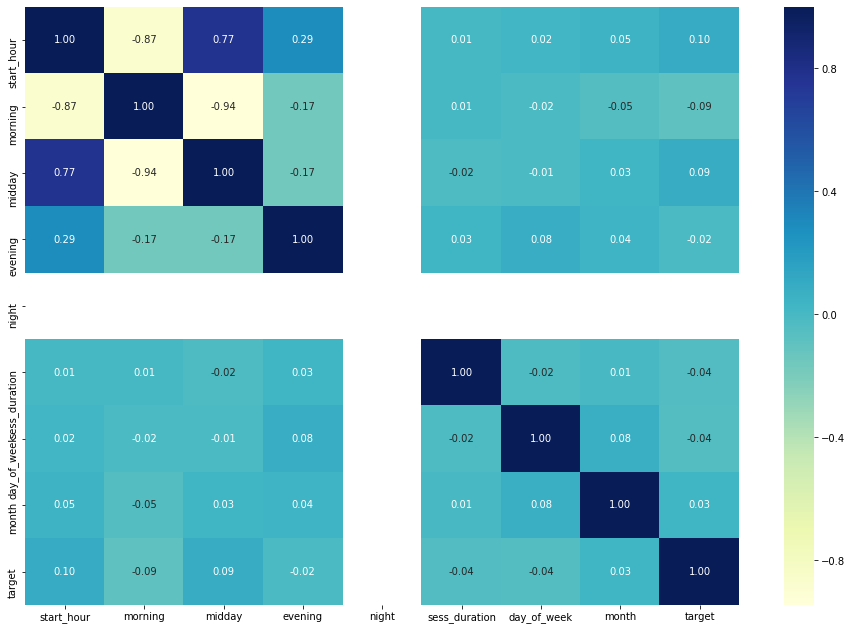

In [ ]:
corr = add_data_train.corr('spearman') 
plt.figure(figsize=(16, 11)) 
ax = sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.2f');
i, k = ax.get_ylim()
ax.set_ylim(i + 0.5, k - 0.5);

In [ ]:
add_data_train = add_data_train.drop('night', 1)
add_data_test = add_data_test.drop('night', 1)

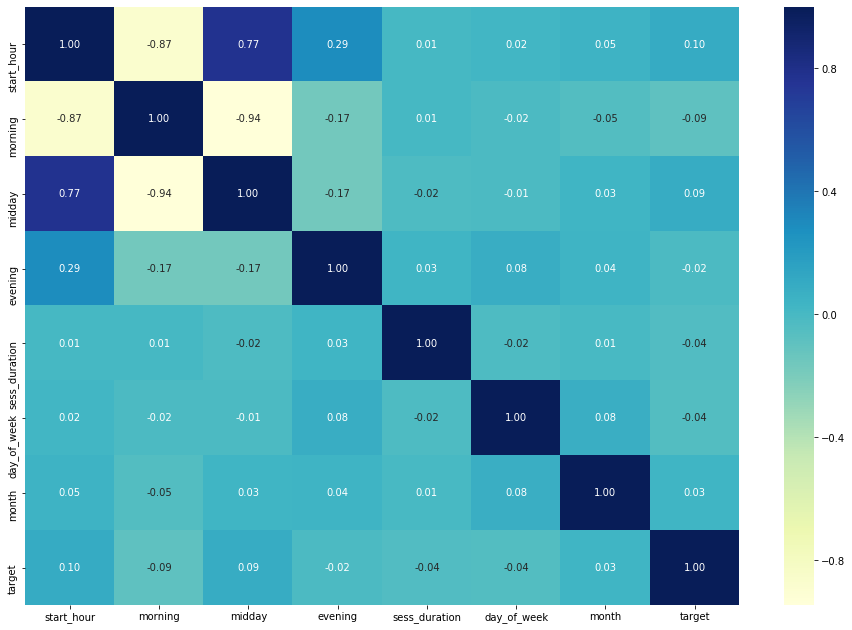

In [ ]:
corr = add_data_train.corr('spearman') 
plt.figure(figsize=(16, 11)) 
ax = sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.2f');
i, k = ax.get_ylim()
ax.set_ylim(i + 0.5, k - 0.5);

In [ ]:
# Show column names and types of additional features
dtype_df = add_data_train.dtypes.reset_index() 
dtype_df.columns = ['Column_name','Column_type'] 
dtype_df

Column_name Column_type
0     start_hour       int64
1        morning       int32
2         midday       int32
3        evening       int32
4  sess_duration     float64
5    day_of_week       int64
6          month       int64
7         target       int64

In [ ]:
# Show at the distribution of some features
feature_list = ['start_hour', 'day_of_week'] 
for column_name in feature_list: 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) 
    fig.suptitle(column_name, fontsize=16) 
    sns.countplot(add_data_train[column_name], ax=ax1) 
    ax1.set_title("Train distribution") 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.countplot(add_data_test[column_name], ax=ax2) 
    ax2.set_title("Test distribution") 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

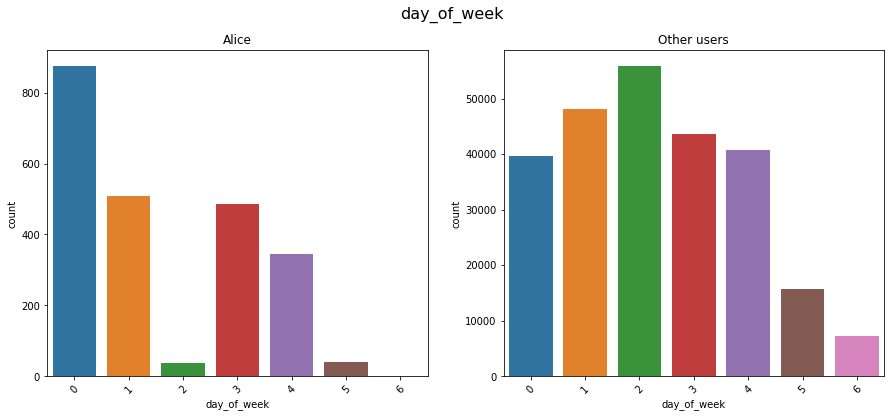

In [ ]:
# Show at the target distribution of some features
for column_name in feature_list:
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6)) 
    fig.suptitle(column_name, fontsize=16) 
    sns.countplot(add_data_train[add_data_train['target'] == 1][column_name], ax=ax1) 
    ax1.set_title("Alice") 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.countplot(add_data_train[add_data_train['target'] == 0][column_name], ax=ax2) 
    ax2.set_title("Other users") 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

In [ ]:
# The target duration of sessions
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x = 'target', y = 'sess_duration', data = add_data_train)

In [ ]:
add_data_train.head(5)

start_hour  morning  midday  evening  sess_duration  day_of_week  \
session_id                                                                     
21669                8        1       0        0       0.000000            5   
54843                8        1       0        0       7.488294            5   
77292                8        1       0        0       1.609438            5   
114021               8        1       0        0       1.386294            5   
146670               8        1       0        0       1.098612            5   

            month  target  
session_id                 
21669           1       0  
54843           1       0  
77292           1       0  
114021          1       0  
146670          1       0

## **One hot encoding**  
**One hot encoding** is a process by which categorical variables are converted into a form  
that could be provided to ML algorithms to do a better job in prediction.

In [ ]:
# Convert categorical variables to dummies using get_dummies
add_train_dummies  = pd.get_dummies(add_data_train , columns=['day_of_week']) 
add_train_dummies.drop(['target'],axis = 1,inplace=True) 
add_test_dummies  = pd.get_dummies(add_data_test,columns=['day_of_week'])

In [ ]:
add_train_dummies.head()

start_hour  morning  midday  evening  sess_duration  month  \
session_id                                                               
21669                8        1       0        0       0.000000      1   
54843                8        1       0        0       7.488294      1   
77292                8        1       0        0       1.609438      1   
114021               8        1       0        0       1.386294      1   
146670               8        1       0        0       1.098612      1   

            day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  \
session_id                                                               
21669                   0              0              0              0   
54843                   0              0              0              0   
77292                   0              0              0              0   
114021                  0              0              0              0   
146670                  0              0              0              0   

            day_of_week_4  day_of_week_5  day_of_week_6  
session_id                                               
21669                   0              1              0  
54843                   0              1              0  
77292                   0              1              0  
114021                  0              1              0  
146670                  0              1              0

## **Standardization**  
Many machine learning algorithms perform better when numerical input variables are scaled to a standard range.  
**Standardization** scales each input variable separately by subtracting the mean (called centering)  
and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.

In [ ]:
names_for_scale = list(add_train_dummies.columns)
scaler = StandardScaler() 
for column_name in names_for_scale : 
    add_train_dummies[column_name] = scaler.fit_transform(add_train_dummies[column_name].values.reshape(-1, 1)) 
    add_test_dummies[column_name] = scaler.transform(add_test_dummies[column_name].values.reshape(-1, 1))

In [ ]:
add_test_dummies.head()

start_hour   morning    midday   evening  sess_duration     month  \
session_id                                                                      
1            -0.407823  1.039061 -0.981280 -0.171577      -0.750303  1.474950   
2            -0.407823  1.039061 -0.981280 -0.171577       0.571882  0.668778   
3             0.858234 -0.962408  1.019077 -0.171577       0.565370  2.012399   
4            -0.724338  1.039061 -0.981280 -0.171577      -1.011969  1.743675   
5             0.858234 -0.962408  1.019077 -0.171577      -0.438748  0.131329   

            day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  \
session_id                                                               
1               -0.436072      -0.487314       -0.53223      -0.459143   
2               -0.436072      -0.487314       -0.53223       2.177972   
3               -0.436072      -0.487314       -0.53223      -0.459143   
4               -0.436072       2.052067       -0.53223      -0.459143   
5               -0.436072      -0.487314       -0.53223      -0.459143   

            day_of_week_4  day_of_week_5  day_of_week_6  
session_id                                               
1               -0.440082       3.879327      -0.172561  
2               -0.440082      -0.257777      -0.172561  
3                2.272305      -0.257777      -0.172561  
4               -0.440082      -0.257777      -0.172561  
5                2.272305      -0.257777      -0.172561

In [ ]:
# Combine the site matrix and additional features
x_train_full = csr_matrix(hstack([train_sites_matrix, add_train_dummies.values])) 
x_test_full = csr_matrix(hstack([test_sites_matrix, add_test_dummies.values])) 
x_train_full.shape, x_test_full.shape

((253561, 50013), (82797, 50013))

## **Cross-validation**
Since we have historical data, interrelated with time, the standard cross-fitting in this case will not work.  
We will use cross-validation with TimeSeriesSplit - cross-validation techniques for time series.  
Its essence lies in the following: we divide the sample, for example, into 5 parts: [1, 2, 3, 4, 5], then we train in the following way

* Fold 1: training [1], Test [2]
* Fold 2: Training [1, 2], Test [3]
* Fold 3: teaching [1, 2, 3], Test [4]
* Fold 4: training [1, 2, 3, 4], Test [5]  
This approach will help to better evaluate the quality of the algorithm.

cross-validation.png

In [ ]:
# 80% - train
# 20% - validation
target = train_df['target']
X_train , X_valid , y_train , y_valid = train_test_split(x_train_full,target ,test_size=0.2) 
tscv = TimeSeriesSplit(n_splits=5);

In [ ]:
%%time
# clf_lr = LogisticRegression(random_state=42, n_jobs=-1)
clf_lr = LogisticRegression(random_state=42, n_jobs=-1, max_iter=500)
clf_lr.fit(X_train, y_train)
preds_lr = clf_lr.predict_proba(X_valid)[:, 1]
print('Train test split LogisticRegression score:% s ROC AUC'% round(roc_auc_score(y_valid, preds_lr), 4))
cross_score_lr = np.mean(cross_val_score(clf_lr, x_train_full, target, scoring = 'roc_auc', n_jobs=-1, cv=tscv))
print('Cross validation LogisticRegression score:% s ROC AUC'% round (cross_score_lr, 4))

Train test split LogisticRegression score:0.9813 ROC AUC
Cross validation LogisticRegression score:0.9115 ROC AUC
Wall time: 40.8 s


In [ ]:
%%time
# clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf_rf = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)
clf_rf.fit(X_train, y_train)
preds_rf = clf_rf.predict_proba(X_valid)[:, 1]
print ('Train test split RandomForestClassifier score:% s ROC AUC'% round(roc_auc_score(y_valid, preds_rf), 4))
cross_score_rf = np.mean (cross_val_score (clf_rf, x_train_full, target, scoring = 'roc_auc', n_jobs=-1, cv=tscv))
print ('Cross validation RandomForestClassifier score:% s ROC AUC'% round (cross_score_rf, 4))

Train test split RandomForestClassifier score:0.9778 ROC AUC
Cross validation RandomForestClassifier score:0.8249 ROC AUC
Wall time: 8min 46s


In [ ]:
%%time
# clf_xgb = xgb.XGBClassifier(random_state = 42, n_jobs=-1)
clf_xgb = xgb.XGBClassifier(random_state = 42, booster = 'gblinear', n_jobs=-1)
clf_xgb.fit(X_train, y_train)
preds_xgb = clf_xgb.predict_proba(X_valid)[:, 1]
print ('Train test split XGBClassifier score:% s ROC AUC'% round(roc_auc_score(y_valid, preds_xgb), 4))
cross_score_xgb = np.mean (cross_val_score (clf_xgb, x_train_full, target, scoring = 'roc_auc', n_jobs=-1, cv=tscv))
print ('Cross validation XGBClassifier score:% s ROC AUC'% round (cross_score_xgb, 4))

Train test split XGBClassifier score:0.9045 ROC AUC
Cross validation XGBClassifier score:0.7654 ROC AUC
Wall time: 32.7 s


In [ ]:
fpr_lr, tpr_lr, threshold = roc_curve(y_valid, preds_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, threshold = roc_curve(y_valid, preds_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, threshold = roc_curve(y_valid, preds_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr_lr, tpr_lr, 'r', label='AUC LR=%0.4f'%roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, 'b', label='AUC RF=%0.4f'%roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, 'g', label='AUC XGB REG=%0.4f'%roc_auc_xgb)
plt.legend(loc='lowerright')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5, 0, 'False Positive Rate')

In [ ]:
def show_confusion_matrix(y_true, y_pred,title='Confusionmatrix'):
    table=confusion_matrix(y_true.values, y_pred)
    fig, ax = plt.subplots(frameon=False)
    fig.set_size_inches(4, 3)
    fig.suptitle(title, fontsize=20)
    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    the_table=ax.table(cellText=table,
                        colWidths=[0.5] * len([0, 1]),
                        rowLabels=['True 0','True 1'], colLabels=['Predicted 0', 'Predicted 1'],
                        cellLoc='center', rowLoc='center', loc="center")
    the_table.set_fontsize(34)
    the_table.scale(1, 4)
    plt.show()

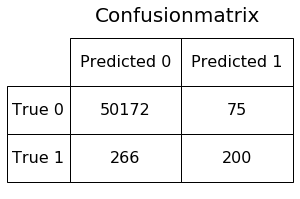

In [ ]:
show_confusion_matrix(y_valid, clf_lr.predict(X_valid))

In [ ]:
show_confusion_matrix(y_valid, clf_rf.predict(X_valid))

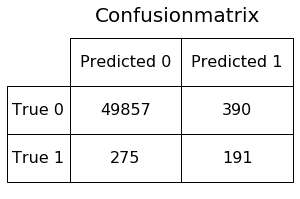

In [ ]:
show_confusion_matrix(y_valid, clf_xgb.predict(X_valid))

In [ ]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed,max_iter=8000,n_jobs=-1,solver='lbfgs').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    return score

In [ ]:
from tqdm import tqdm
# List of possible C-values
Cs = np.logspace(-1, 1, 20)

scores = []

for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████| 20/20 [04:19<00:00, 12.98s/it]


In [ ]:
Cs

array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])

In [ ]:
max(scores)

0.9811669702477037

In [ ]:
final_model = LogisticRegression(random_state = 17, C = Cs[np.argmax(scores)],n_jobs=1) 
final_model.fit(X_train,y_train) 
print('ROC_AUC on the test sample: {} '.format(round(roc_auc_score(y_valid,final_model.predict_proba(X_valid)[:,1]),4)))

ROC_AUC on the test sample: 0.9812 
